# This notebook contains the final scripts used and analyses to identify the CSD from the ddRADseq dataset of <i>Caspers wasps</i> 


In [1]:
%matplotlib inline
from __future__ import division
import os
import Incremental_U as IncU 
import Incremental_C as IncC
import Incremental_Pop_mod as IncPop
import MISC_RAD_tools as MISC
import pprint
import subprocess

In [2]:
%load_ext rpy2.ipython

In [4]:
%%bash

wd=/home/djeffrie/Data/Caspers_data/CSD  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered_adegenet.vcf

/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_adegenet_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/Caspers_data/CSD/batch_1_adegenet_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/Caspers_data/CSD/batch_1_adegenet_plink
  --recode A
  --vcf /home/djeffrie/Data/Caspers_data/CSD/batch_1_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/Caspers_data/CSD/batch_1_adegenet_plink-temporary.bed +
/home/djeffrie/Data/Caspers_data/CSD/batch_1_adegenet_plink-temporary.bim +
/home/djeffrie/Data/Caspers_data/CSD/batch_1_adegenet_plink-temporary.fam
written.
2674 variants loaded from .bim file.
136 people (0 males, 0 females, 136 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/home/djeffrie/Data/Caspers_data/CSD/batch_1_adegenet_plink.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main 

In [5]:
%%bash

wd=/home/djeffrie/Data/Caspers_data/CSD

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_adegenet_plink.raw  $wd/batch_1_heatmap_input


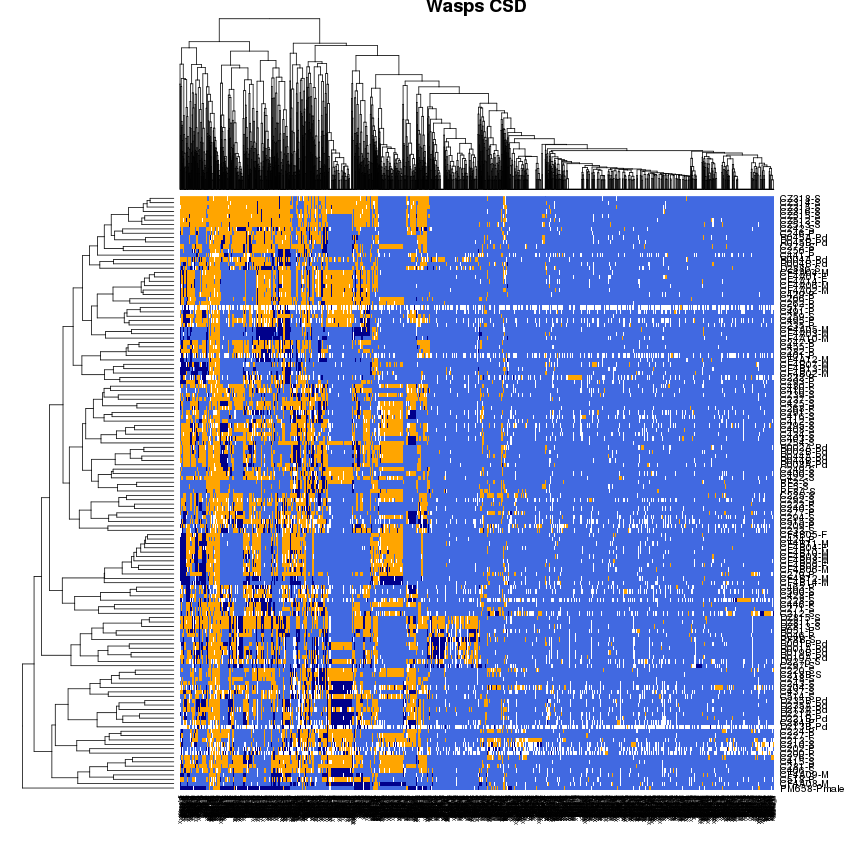

In [6]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/Caspers_data/CSD/batch_1_heatmap_input.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "Wasps CSD")


In [21]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/Caspers_data/CSD/") 

## All SNPs (about 80,000)
XYdata <- read.PLINK('batch_1_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Sex information:
sexes <- read.delim("Sex_ID_info_heterozygosity.txt", header = F)

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(XYdata, parallel = TRUE, n.cores = 2, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



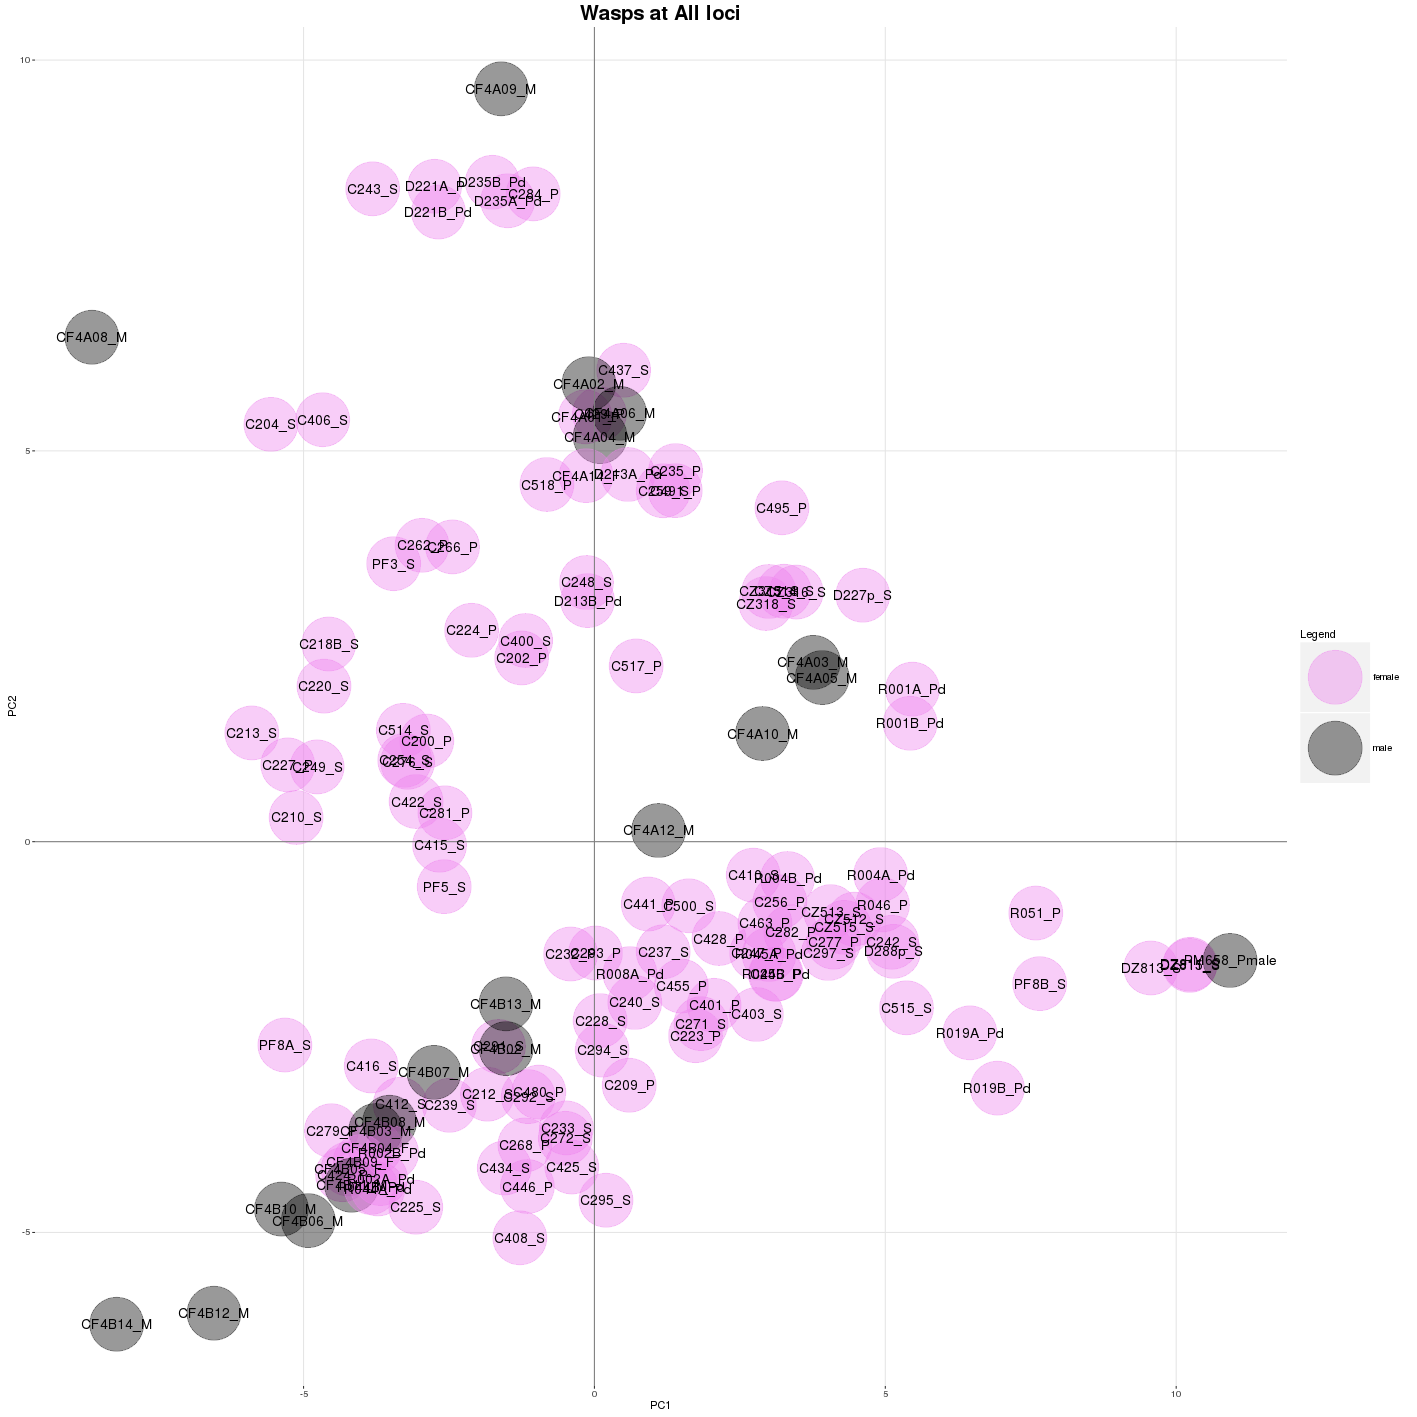

In [25]:
%%R -w 50 -h 50 -u cm
## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("Sex_ID_info_heterozygosity.txt", header = F)
Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "Wasps at All loci", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = c("violet", "black"),
           func_cex = 5) ## Size of points and text in plots) ## Colours to use

### Finding CSD markers


In [3]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Riberica/Stacks_trimmed/IDd/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/Caspers_data/CSD/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/Caspers_data/CSD/Sex_ID_info_heterozygosity.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 7 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 0.9 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 0.9 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.5 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 4 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.


So we are saying that a locus must be heterozygous in at least 50% of females and homozygous in 90% of males!

In [4]:
XYset, ZWset = MISC.Super_SLM_finder(Parameter_dict, "010", write_files=False)


##### Using SNP heterozygosity approach #####
 
Number of loci = 2674
Number of samples = 136
Number of loci with too few samples = 0
Number of loci with low MAF = 1380
Number of loci with enough data = 1293
Number of putative X linked snps = 1
Number of putative X linked tags = 1
Number of putative Z linked markers = 30
Number of putative Z linked tags = 30

 ### DONE! ### 


 ## After merging tags accross methods ## 

Final number of XY tags = 1
Final number of ZW tags = 30


In [5]:
vcf_path = "/home/djeffrie/Data/Caspers_data/CSD/batch_1.vcf"

MISC.filter_vcf(vcf_path, ZWset , "ZW_linked_snps_freq_het.vcf")

In [6]:
%%bash

wd=/home/djeffrie/Data/Caspers_data/CSD/  ## just change this line

## XY only data 
sed 's/_/-/g' $wd/ZW_linked_snps_freq_het.vcf > $wd/ZW_linked_snps_freq_het_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/ZW_linked_snps_freq_het_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/ZW_linked_plink 

PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/Caspers_data/CSD//ZW_linked_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/Caspers_data/CSD//ZW_linked_plink
  --recode A
  --vcf /home/djeffrie/Data/Caspers_data/CSD//ZW_linked_snps_freq_het_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf: /home/djeffrie/Data/Caspers_data/CSD//ZW_linked_plink-temporary.bed +
/home/djeffrie/Data/Caspers_data/CSD//ZW_linked_plink-temporary.bim +
/home/djeffrie/Data/Caspers_data/CSD//ZW_linked_plink-temporary.fam written.
30 variants loaded from .bim file.
136 people (0 males, 0 females, 136 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/home/djeffrie/Data/Caspers_data/CSD//ZW_linked_plink.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 136 

In [8]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/Caspers_data/CSD/") 

## All SNPs (about 80,000)
XYdata <- read.PLINK('ZW_linked_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Sex information:
sexes <- read.delim("Sex_ID_info_heterozygosity.txt", header = F)

## Running PCA ---------------------------------------------------------------------------------------

pca2 <- glPca(XYdata, parallel = TRUE, n.cores = 2, nf = 5) 


/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



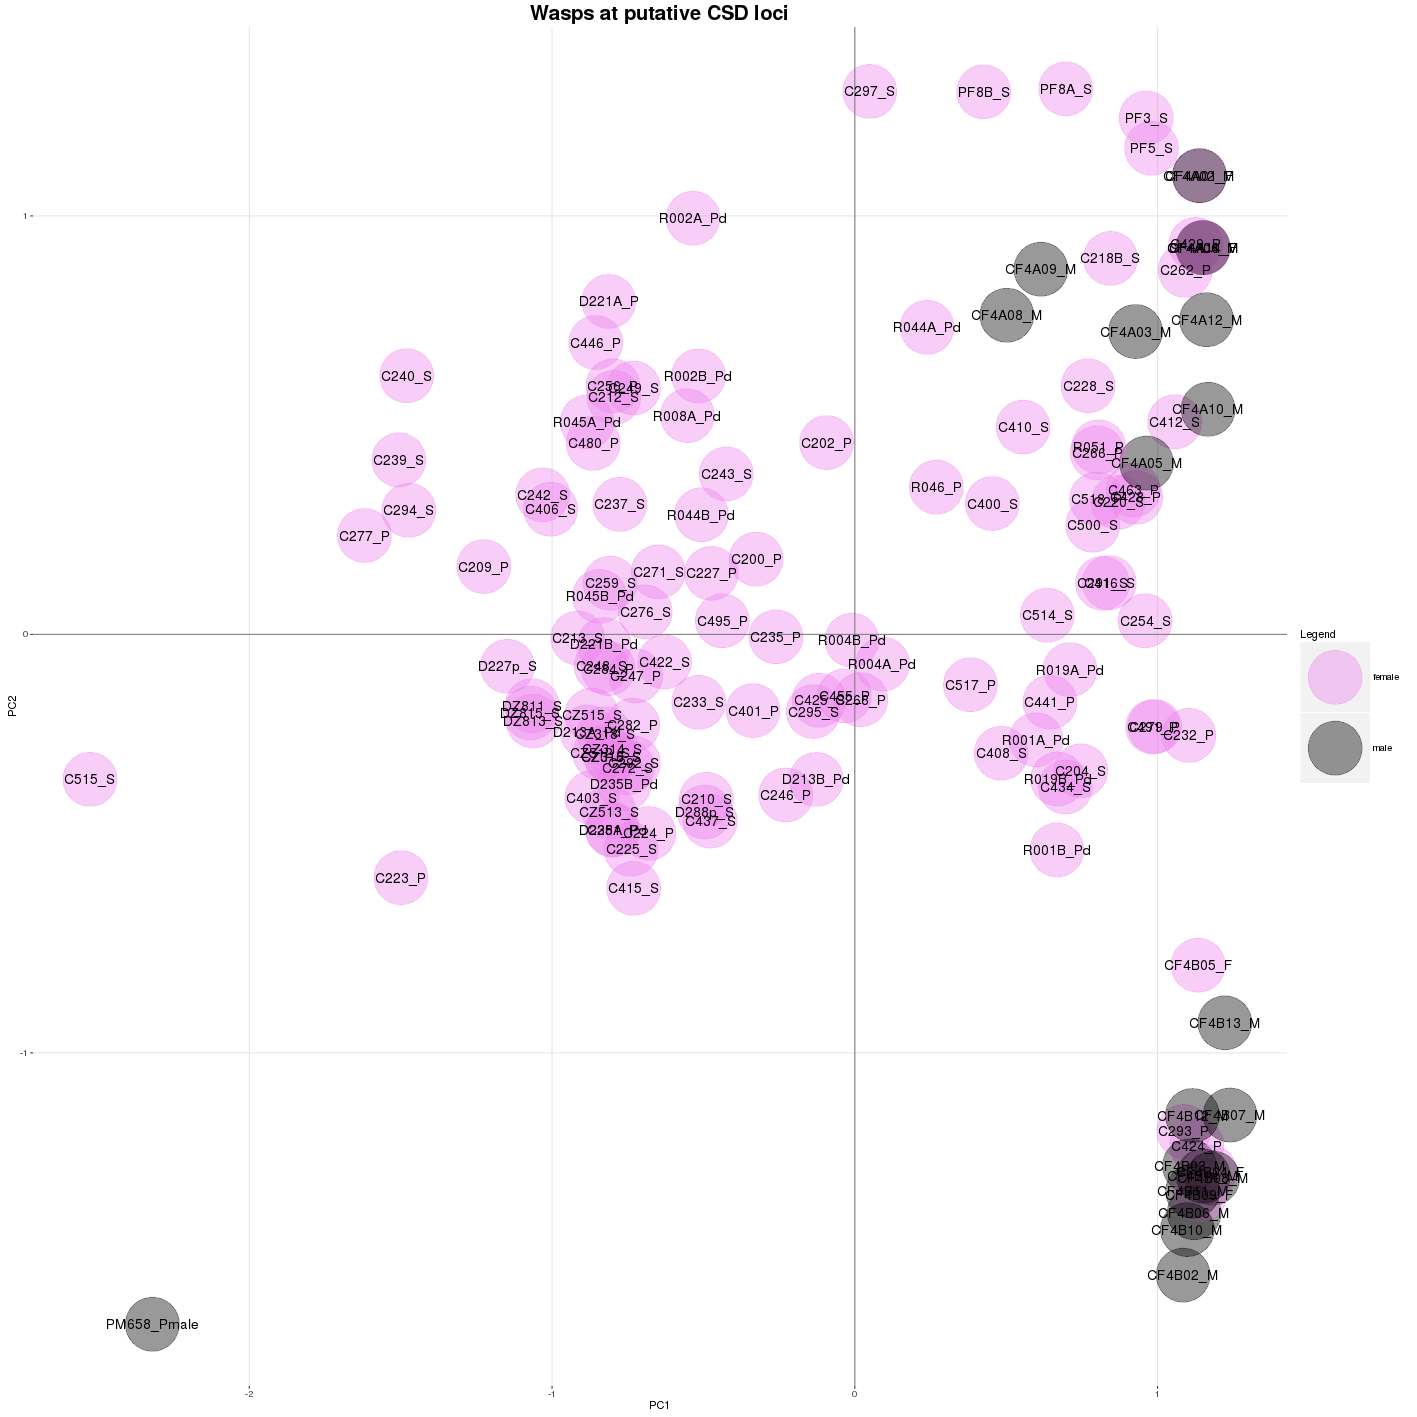

In [26]:
%%R -w 50 -h 50 -u cm
## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("Sex_ID_info_heterozygosity.txt", header = F)
Sex_sorter(pca2,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "Wasps at putative CSD loci", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = c("violet", "black"),
           func_cex = 5) ## Size of points and text in plots) ## Colours to use